In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:

import os
import sys
sys.path.append(f"{os.getcwd()}/../src")
import adv
from adv import to_jet, center_on

In [6]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:2


## Load in the Z+Jets dataset:

In [7]:
ds = adv.ZJetsDataset(device=device, use_cache=True, dir="../data/adv")

n_train = int(0.8*len(ds))
n_val = len(ds)-n_train

ds_train, ds_val = torch.utils.data.random_split(ds, (n_train, n_val))

x_train, y_train = ds_train[:]
x_val, y_val = ds_val[:]

## Build a deep-sets classifier
The "deep sets" architecture ([arXiv:1703.06114](https://arxiv.org/abs/1703.06114)) is useful for this problem, as it is *permutation invariant*.
Since we often order particles by descending pT as a convention, our adversary might simply learn to disturb this order, which is not a concern, since we would fix that issue in preprocessing.

Similarly, while it is very helpful to center the particles about their jet axis, we will do this step *within the network*, rather than as a preprocessing step. That is, we will also make our network invariant to shifts in the (eta, phi) of the jet axis, since we would conventionally remove any such shift in preprocessing, and therefore don't care about adversarial attacks on this feature.

Deep sets may sound exotic, but basically one just has to apply a neural network to each of the (variable-length) inputs, to encode or embed the original observables into an abstract latent space. Then we simply sum the result and feed it into a normal dense classifier network.

In [8]:
# Simple deep-sets type classifier.
# It expects as input a tensor with shape (d1, d2, ... , dn-1, dn, 3).
# In our case "dn" should correspond to the number of particles, which will get summed over.
# The latent space encoding will have shape (d1, d2, ... , dn-1, L),
# where L is a hyperparameter representing the dimensionality of the latent space.
# The output will have shape (d1, d2, ..., dn-1, 2), where the last dimension are
# raw logits for binary crossentropy.
class JetClassifier(torch.nn.Module):
    def __init__(self, L=32, u=128):
        super(JetClassifier, self).__init__()
        
        # "inner" network. An identical copy of
        # this subnetwork is applied to each input
        # independently.
        self.f1 = torch.nn.ModuleList([
            nn.Linear(3,u),
            nn.Dropout(0.25),
            nn.Linear(u, u),
            nn.Dropout(0.25),
            nn.Linear(u, L),
        ])
        
        # "outer" network. Simple dense network that
        # acts on the L-dimensional summed latent space
        # encoding, and outputs 2 categorical logits for
        # classification score.
        self.f2 = torch.nn.ModuleList([
            nn.Linear(L, u),
            nn.Linear(u, u),
            nn.Linear(u, 2),
        ])
        
    def forward(self, x0):
        # we peel off the pT of each input particle, in order
        # to define a mask. Only particles with nonzero pT
        # will contribute to the latent space sum.
        # this is a convenient way to handle a variable-length input
        # with a fixed input tensor size.
        pt0 = torch.split(x0, 1, dim=-1)[0]
        
        # compute the jet kinematics for the particles in x0
        j = to_jet(x0)
        # center the particles about their jet axis
        x = center_on(j, x0)
        
        for l in self.f1[:-1]:
            x = F.relu(l(x))
        x = self.f1[-1](x)
        
        x = torch.sum((pt0>0)*x, axis=-2)
        
        for l in self.f2[:-1]:
            x = F.relu(l(x))
        x = self.f2[-1](x)
        return x

## Train the network

This is just your standard supervised training loop:

In [9]:
model = JetClassifier().to(device)

# note: we are opting not to reduce the loss function, for reasons that will matter later on.
# normally, the average is taken so that the loss is a scalar
# that can be optimized.
model.loss_fn = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.Adam(model.parameters())

# to store metrics history
h = {}

# you might need to adjust these depending on your available GPU memory.
batch_size = 1024
val_batch_size = 4096

In [10]:
epochs = 8

nbatch_train = x_train.shape[0]//batch_size
nbatch_val = x_val.shape[0]//val_batch_size

for ep in range(epochs):
    running_loss = 0
    running_acc = 0
    
    # set the model to train mode (activates dropout)
    model.train()
    
    # shuffle the data indices
    idxs = torch.randperm(x_train.shape[0], device=device)
    
    print("Training epoch", ep)
    
    for ib in range(nbatch_train):
        bidx = idxs[ib*batch_size:(ib+1)*batch_size]
        x, y = x_train[bidx], y_train[bidx]
        
        optimizer.zero_grad()
        
        outputs = model(x)
        running_acc += (torch.max(outputs, axis=1)[1] == y).sum().item()
        
        loss = model.loss_fn(outputs, torch.squeeze(y,axis=-1)).mean()
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    running_loss /= (len(x_train)//batch_size)
    running_acc /= len(x_train)
    
    model.eval()
    with torch.no_grad():
        val_acc = 0
        val_loss = 0

        for ib in range(nbatch_val):
            x = x_val[ib*val_batch_size:(ib+1)*val_batch_size]
            y = y_val[ib*val_batch_size:(ib+1)*val_batch_size]
            output = model(x)
            loss = model.loss_fn(output, y).mean()
            val_loss += loss.item()
            val_acc += (torch.max(output,axis=1)[1] == y).sum().item()
        val_loss /= nbatch_val
        val_acc /= nbatch_val*val_batch_size
    
    print("    loss: %.4f   acc: %.3f    val_loss: %.4f   val_acc: %.3f" % (running_loss, running_acc, val_loss, val_acc))
    
    h.setdefault('loss', []).append(running_loss)
    h.setdefault('acc', []).append(running_acc)
    h.setdefault('val_loss', []).append(val_loss)
    h.setdefault('val_acc', []).append(val_acc)

Training epoch 0


    loss: 0.6074   acc: 0.663    val_loss: 0.5710   val_acc: 0.703
Training epoch 1


    loss: 0.5406   acc: 0.729    val_loss: 0.5603   val_acc: 0.715
Training epoch 2


KeyboardInterrupt: 

## Training Results
You should get to ~80% accuracy pretty quick.

We can also inspect the distribution of the NN predictions to see that it has done a farily good job of separating signal from background. Note that in making the second figure, we must convert the raw logit output of the network to softmax in order to interpret it as a posterior probability.

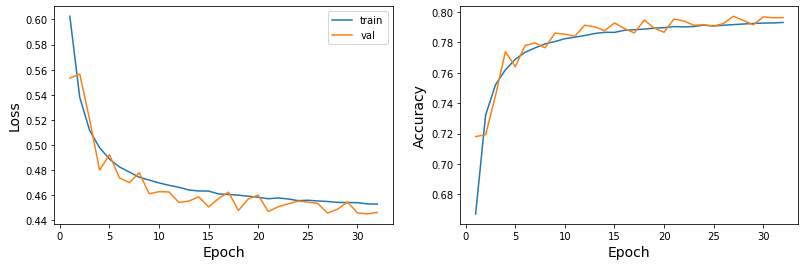

In [71]:
plt.figure(figsize=plt.figaspect(0.3))
xep = np.arange(len(h['loss']))+1
plt.subplot(121)
plt.plot(xep, h['loss'], label='train')
plt.plot(xep, h['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(xep, h['acc'], label='train')
plt.plot(xep, h['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

In [72]:
npred = 2048 # reduce if you're out of GPU memory
with torch.no_grad():
    model.eval()
    pred_val = torch.softmax(model(x_val[:npred]), axis=-1)[:,1].cpu().numpy()

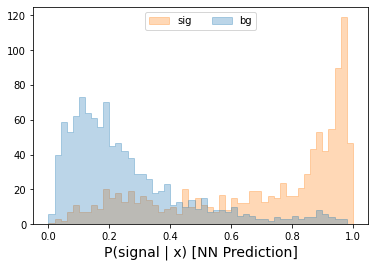

In [73]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=50, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig']);
plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

## Save model

Let's save our trained up model so that we can use it right away in the next notebook.

In [74]:
torch.save(model, 'classifier1.pt')

/ssd/scratch/cshimmin/.virtualenvs/jupyter/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type JetClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
